In [8]:
import os
import sys
import random
import numpy as np
import cv2
from PIL import Image

import tensorflow as tf
from tensorflow import keras

## Seeding
seed = 42
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [9]:
import math
class DataGen(keras.utils.Sequence):

    def __init__(self, path, batch_size, image_size, labels=True, shuffle=True, file_list=None):
        self.image_size = image_size
        self.batch_size = batch_size
        self.path = path
        self.list_IDs = os.listdir(os.path.join(self.path, 'images'))
        if file_list is not None:
            self.list_IDs = file_list
        else:
            self.list_IDs = os.listdir(os.path.join(self.path, 'images'))
        if labels:
            self.label_IDs = os.listdir(os.path.join(self.path, 'masks'))
        self.shuffle = shuffle
        self.on_epoch_end()

    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, 'images', id_name)
        mask_path = os.path.join(self.path, 'masks', id_name)

        ## Reading Image
        image = cv2.imread(image_path, 1)[:,:,::-1]
        image = cv2.resize(image, self.image_size)
        mask = cv2.imread(mask_path, 1)[:,:,::-1]
        mask = cv2.resize(mask[:,:,1], self.image_size)
        mask = np.expand_dims(mask, axis=-1)

        ## Normalizaing
        image = image/255.0
        mask = mask/255.0

        return image, mask

    def __getitem__(self, index):

        if(index+1)*self.batch_size > len(self.list_IDs):
            self.batch_size = len(self.list_IDs) - index*self.batch_size

        files_batch = self.list_IDs[index*self.batch_size : (index+1)*self.batch_size]

        image = []
        mask  = []
        for id_name in files_batch:
          _img, _mask = self.__load__(id_name)
          image.append(_img)
          mask.append(_mask)

        image = np.array(image)
        mask  = np.array(mask)

        return image, mask

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    def __len__(self):
        return math.ceil(len(self.list_IDs) / self.batch_size)

In [10]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))

    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [11]:
parameters = {
    'image_size': (640, 640),
    'epochs': 50,
    'batch_size': 32,
    'optimizer': 'adam',
    'loss': 'binary_crossentropy',
    'metric': 'acc',
    'test_split': 0.2
}

In [12]:
image_size = parameters['image_size'][0]

model = UNet()
model.compile(optimizer=parameters['optimizer'], loss=parameters['loss'], metrics=parameters['metric'])
model.summary()
# Save the model
model.save('model_UNet.h5')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 640, 640, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 640, 640, 16)         448       ['input_2[0][0]']             
                                                                                                  
 conv2d_20 (Conv2D)          (None, 640, 640, 16)         2320      ['conv2d_19[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 320, 320, 16)         0         ['conv2d_20[0][0]']           
 g2D)                                                                                       

In [13]:
from pathlib import Path
path = Path("C:\\Users\\Haroun\\Desktop\\YOLO_CROSS_VALIDATION\\combined_kaggletest_folded")

for i in range(1, 6):  # Itérer de fold1 à fold5
    fold_path = path / f'fold_{i}'
    train_path = fold_path / 'train'
    val_path = fold_path / 'val'
    test_path = fold_path / 'test'

    train_files = os.listdir(train_path/ 'images')
    val_files = os.listdir(val_path/ 'images')
    train_steps = len(train_files) // parameters['batch_size']
    valid_steps = len(val_files) // parameters['batch_size']

    # Create generators for training and validation
    train_generator = DataGen(train_path, batch_size=parameters['batch_size'], image_size=parameters['image_size'], file_list=train_files)
    valid_generator = DataGen(val_path, batch_size=parameters['batch_size'], image_size=parameters['image_size'], file_list=val_files)

    parameters['train_steps'] = train_steps
    parameters['valid_steps'] = valid_steps
    parameters['train_generator'] = train_generator
    parameters['validation_generator'] = valid_generator

    history = model.fit_generator(parameters['train_generator'], validation_data=parameters['validation_generator'],
                              steps_per_epoch=parameters['train_steps'],
                              validation_steps=parameters['valid_steps'], epochs=parameters['epochs'])
    
    np.save(f"weights_combined_kaggletest_fold{i}.npy", model.get_weights())

C:\Users\Haroun\AppData\Local\Temp\ipykernel_8732\721359935.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(parameters['train_generator'], validation_data=parameters['validation_generator'],


Epoch 1/50
34/34 [==============================] - 210s 6s/step - loss: 0.2061 - acc: 0.9586 - val_loss: 0.0946 - val_acc: 0.9745
Epoch 2/50
34/34 [==============================] - 155s 5s/step - loss: 0.0770 - acc: 0.9767 - val_loss: 0.1324 - val_acc: 0.9780
Epoch 3/50
34/34 [==============================] - 154s 5s/step - loss: 0.0748 - acc: 0.9786 - val_loss: 0.0708 - val_acc: 0.9780
Epoch 4/50
34/34 [==============================] - 155s 5s/step - loss: 0.0652 - acc: 0.9766 - val_loss: 0.0572 - val_acc: 0.9780
Epoch 5/50
34/34 [==============================] - 154s 5s/step - loss: 0.0541 - acc: 0.9770 - val_loss: 0.0707 - val_acc: 0.9780
Epoch 6/50
34/34 [==============================] - 155s 5s/step - loss: 0.0568 - acc: 0.9796 - val_loss: 0.0549 - val_acc: 0.9819
Epoch 7/50
34/34 [==============================] - 155s 5s/step - loss: 0.0486 - acc: 0.9825 - val_loss: 0.0507 - val_acc: 0.9817
Epoch 8/50
34/34 [==============================] - 155s 5s/step - loss: 0.0562 - a

In [40]:
from tensorflow.keras.models import load_model

# To load the model later
model = load_model('model_UNet.h5')

# Print the loaded model summary
model.summary()

weights_path = Path("C:\\Users\\Haroun\\Desktop\\jupyter\\weights_AZH_fold1.npy")
# Load the saved weightsn
weights = np.load(weights_path, allow_pickle=True) #change fold weights 
model.set_weights(weights)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 640, 640, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 640, 640, 16)         448       ['input_2[0][0]']             
                                                                                                  
 conv2d_20 (Conv2D)          (None, 640, 640, 16)         2320      ['conv2d_19[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 320, 320, 16)         0         ['conv2d_20[0][0]']           
 g2D)                                                                                       

1/1 [==============================] - 0s 321ms/step


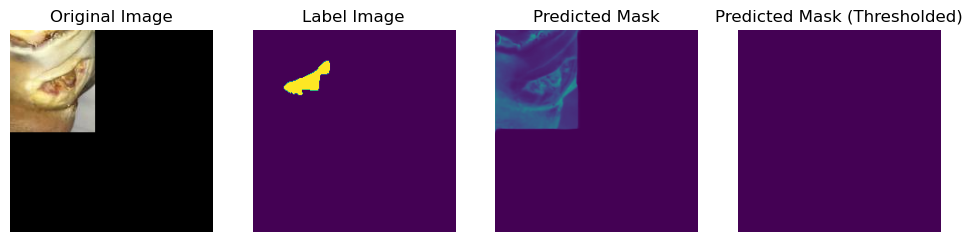

In [32]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
test_pix = 'c:/Users/Haroun/Desktop/YOLO_CROSS_VALIDATION/AZHWoundsDB_folded/fold_1/test/images/0a5a3ada2bb75c4af2daf8e4726bf099_2.png'
img = mpimg.imread(test_pix)

# Resize the image
img_resized = cv2.resize(img, (640, 640))
# Expand dimensions to create a batch of size 1 (required for model.predict)
img_for_prediction = np.expand_dims(img_resized, axis=0)

# Make predictions
prediction = model.predict(img_for_prediction)

threshold = 0.7

# Apply threshold to the predicted mask
#thresholded_mask = (prediction > threshold).astype(np.uint8)
thresholded_mask = (prediction.squeeze() > threshold).astype(np.uint8)

test_label = 'c:/Users/Haroun/Desktop/YOLO_CROSS_VALIDATION/AZHWoundsDB_folded/fold_1/test/masks/0a5a3ada2bb75c4af2daf8e4726bf099_2.png'
img_label = mpimg.imread(test_label)

# Resize the image

# Visualize the results
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Resized Image (before normalization)
plt.subplot(1, 4, 2)
plt.imshow(img_label)
plt.title('Label Image')
plt.axis('off')

# Predicted Mask
plt.subplot(1, 4, 3)
plt.imshow(prediction.squeeze(), cmap='viridis')  # Adjust cmap based on your segmentation task
plt.title('Predicted Mask')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(thresholded_mask, cmap='viridis')  # Adjust cmap based on your segmentation task
plt.title('Predicted Mask (Thresholded)')
plt.axis('off')

plt.show()


1/1 [==============================] - 0s 110ms/step


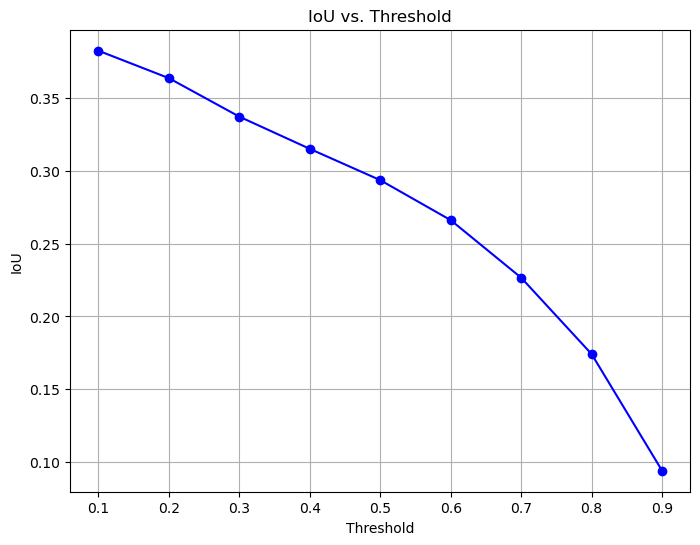

1/1 [==============================] - 0s 112ms/step


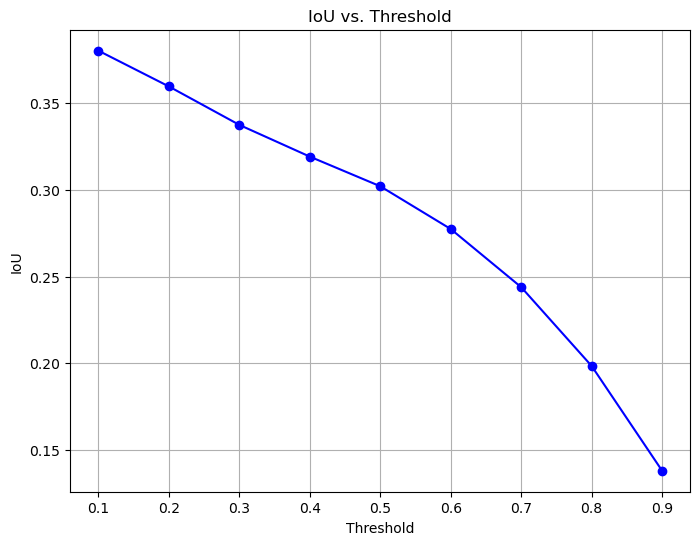

1/1 [==============================] - 0s 106ms/step


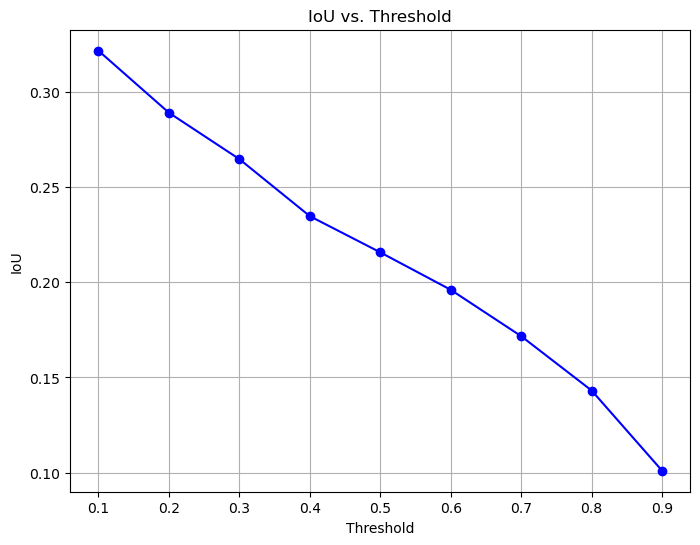

1/1 [==============================] - 0s 116ms/step


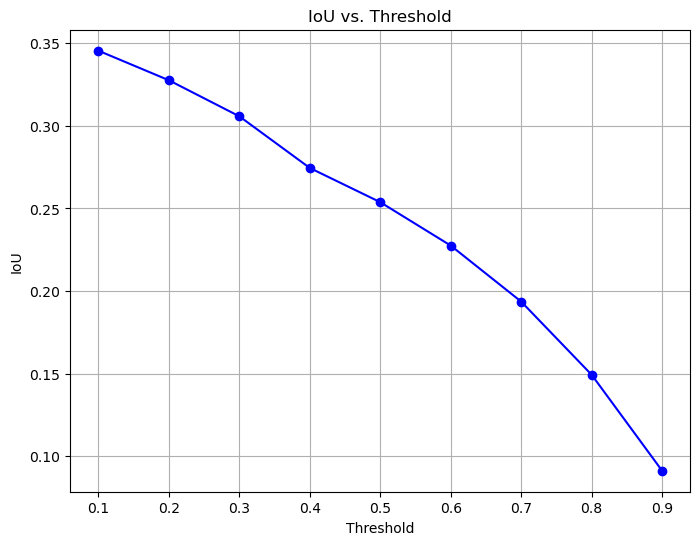

1/1 [==============================] - 0s 107ms/step


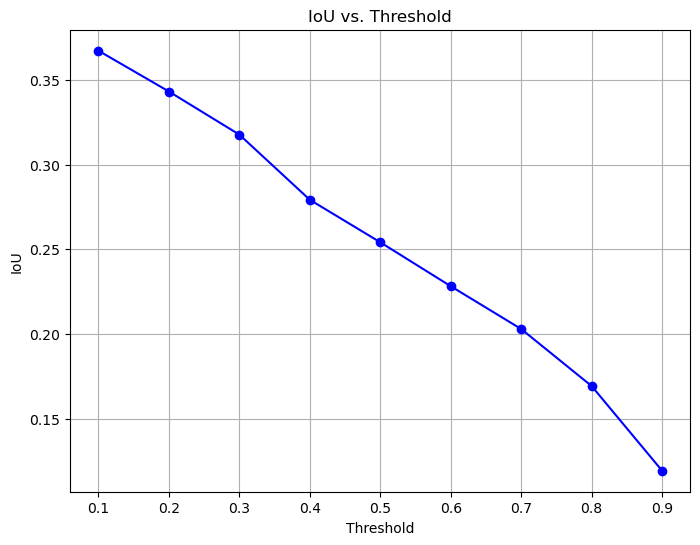

In [49]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
import cv2
import matplotlib.image as mpimg

for i in range(1,6):
    # To load the model later
    model = load_model('model_UNet.h5')

    weights_path = Path(f"C:\\Users\\Haroun\\Desktop\\jupyter\\weights_kaggle_fold{i}.npy")
    # Load the saved weightsn
    weights = np.load(weights_path, allow_pickle=True) #change fold weights 
    model.set_weights(weights)

    test_path = Path("C:\\Users\\Haroun\\Desktop\\YOLO_CROSS_VALIDATION\\AZH_processed")

    # fold_path = test_path / f'fold_{i}' #CHANGE FOR THE RIGHT WEIGHTS 
    # test_images = fold_path / 'test/images'
    # test_labels = fold_path / 'test/masks'
    test_images = test_path / 'images'
    test_labels = test_path / 'masks'
    test_dir_fname = os.listdir(test_images)
    test_dir_labels = os.listdir(test_labels)

    # Load label images as numpy arrays
    label_images = [cv2.resize(mpimg.imread(os.path.join(test_labels, img_file)), (640, 640)) for img_file in test_dir_fname]
    #label_images = [np.expand_dims(label, axis=-1) for label in label_images]  # Add channel dimension

    # Define a range of threshold values
    threshold_values = np.linspace(0.1, 0.9, num=9)

    iou_scores = []

    for threshold in threshold_values:
        # Apply threshold to all predicted masks
        thresholded_masks = []
        for img_file, label in zip(test_dir_fname, label_images):
            # Load test image
            img_path = os.path.join(test_images, img_file)
            img = cv2.resize(mpimg.imread(img_path), (640, 640))

            # Predict mask
            predicted_mask = (model.predict(np.expand_dims(img, axis=0)).squeeze() > threshold).astype(np.uint8)
            thresholded_masks.append(predicted_mask)

        # Calculate IoU for the current threshold
        
        for j, (label, pred) in enumerate(zip(label_images, thresholded_masks)):
            if label.flatten().shape != pred.flatten().shape:
                print(f"Inconsistent shapes for image {j}: {label.flatten().shape} vs {pred.flatten().shape}")

        iou_scores_per_threshold = [jaccard_score(label.flatten().astype(np.uint8), pred.flatten(), zero_division=1) for label, pred in zip(label_images, thresholded_masks)]
        average_iou = np.mean(iou_scores_per_threshold)

        iou_scores.append(average_iou)

    # Plot the IoU vs. Threshold curve
    plt.figure(figsize=(8, 6))
    plt.plot(threshold_values, iou_scores, marker='o', linestyle='-', color='b')
    plt.title('IoU vs. Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('IoU')
    plt.grid(True)
    plt.savefig(f'unet_iou_kaggle_azh_fold{i}.png') #change fold 
    plt.show()


1/1 [==============================] - 0s 113ms/step


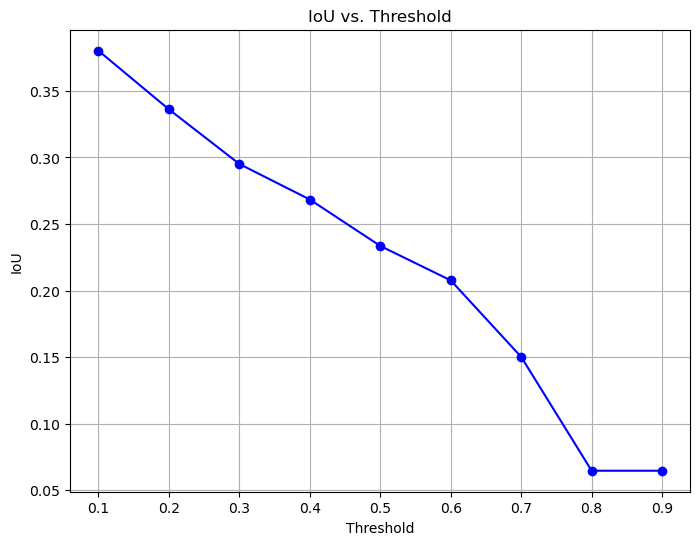

1/1 [==============================] - 0s 115ms/step


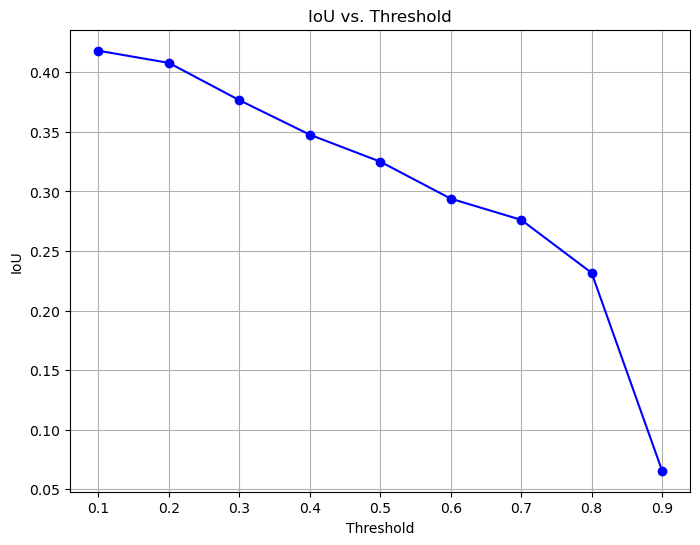

1/1 [==============================] - 0s 113ms/step


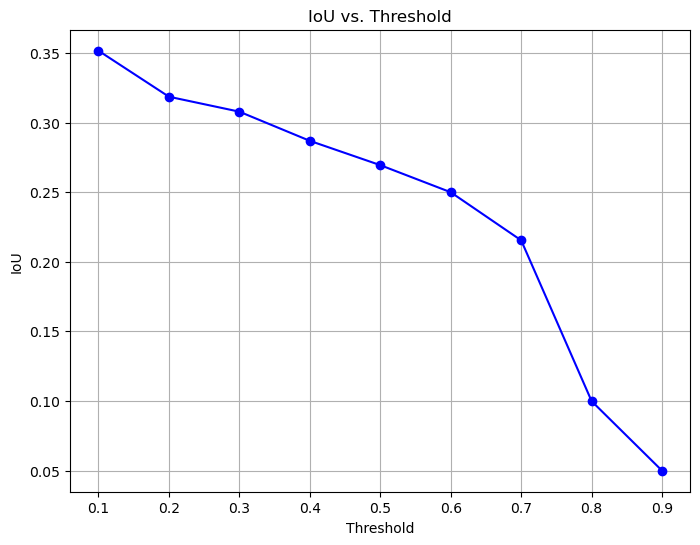

1/1 [==============================] - 0s 137ms/step


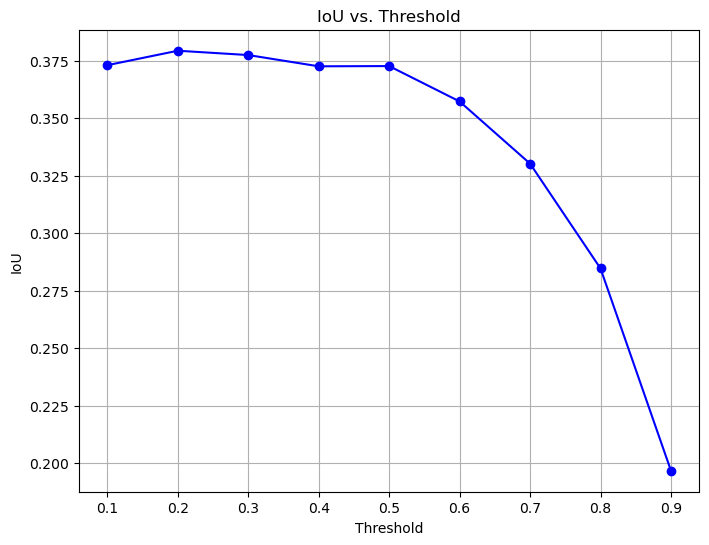

1/1 [==============================] - 0s 136ms/step


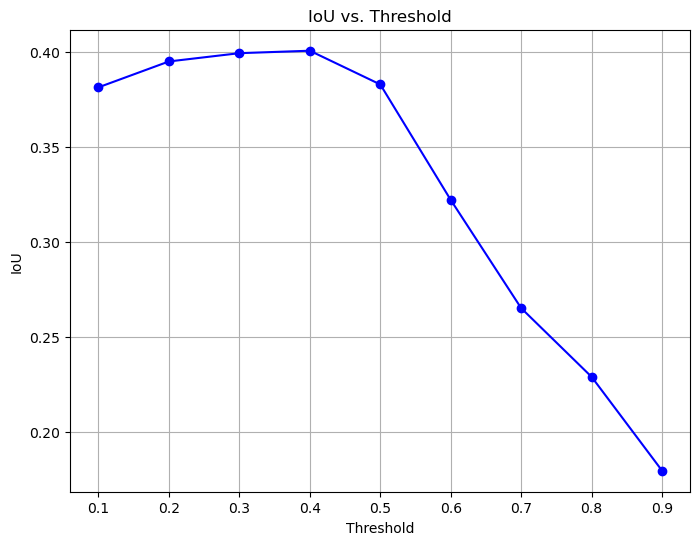

In [60]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.image as mpimg
from pathlib import Path
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model

# Initialize a DataFrame to store the results
columns = ["Threshold", "IoU", "Precision", "Recall", "F1 Score", "Dice Coefficient"]
results_df = pd.DataFrame(columns=columns)

# Loop over folds
for i in range(1,6):
    # To load the model later
    model = load_model('model_UNet.h5')
    weights_path = Path(f"C:\\Users\\Haroun\\Desktop\\jupyter\\weights_combined_AZHtest_fold{i}.npy")
    # Load the saved weights
    weights = np.load(weights_path, allow_pickle=True)
    model.set_weights(weights)
    test_path = Path("C:\\Users\\Haroun\\Desktop\\YOLO_CROSS_VALIDATION\\combined_AZHtest_folded")
    fold_path = test_path / f'fold_{i}' #CHANGE FOR THE RIGHT WEIGHTS 
    test_images = fold_path / 'test/images'
    test_labels = fold_path / 'test/masks'
    # test_images = test_path / 'images'
    # test_labels = test_path / 'masks'
    test_dir_fname = os.listdir(test_images)
    test_dir_labels = os.listdir(test_labels)

    # Load label images as numpy arrays
    label_images = [cv2.resize(mpimg.imread(os.path.join(test_labels, img_file)), (640, 640)) for img_file in test_dir_fname]

    # Define a range of threshold values
    threshold_values = np.linspace(0.1, 0.9, num=9)

    # Initialize lists to store metrics for each threshold
    iou_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    dice_scores = []

    for threshold in threshold_values:
        # Apply threshold to all predicted masks
        thresholded_masks = []
        for img_file, label in zip(test_dir_fname, label_images):
            # Load test image
            img_path = os.path.join(test_images, img_file)
            img = cv2.resize(mpimg.imread(img_path), (640, 640))
            # Predict mask
            predicted_mask = (model.predict(np.expand_dims(img, axis=0)).squeeze() > threshold).astype(np.uint8)
            thresholded_masks.append(predicted_mask)

        # Calculate metrics for the current threshold
        for j, (label, pred) in enumerate(zip(label_images, thresholded_masks)):
            if label.flatten().shape != pred.flatten().shape:
                print(f"Inconsistent shapes for image {j}: {label.flatten().shape} vs {pred.flatten().shape}")

        iou_scores_per_threshold = [jaccard_score(label.flatten().astype(np.uint8), pred.flatten(), zero_division=1) for label, pred in zip(label_images, thresholded_masks)]
        precision_scores_per_threshold = [precision_score(label.flatten().astype(np.uint8), pred.flatten(), zero_division=1) for label, pred in zip(label_images, thresholded_masks)]
        recall_scores_per_threshold = [recall_score(label.flatten().astype(np.uint8), pred.flatten(), zero_division=1) for label, pred in zip(label_images, thresholded_masks)]
        f1_scores_per_threshold = [f1_score(label.flatten().astype(np.uint8), pred.flatten(), zero_division=1) for label, pred in zip(label_images, thresholded_masks)]

        # Calculate Dice coefficient for the current threshold
        dice_scores_per_threshold = [2 * np.sum(label.flatten().astype(np.uint8) * pred.flatten()) /np.where((np.sum(label.flatten().astype(np.uint8)) + np.sum(pred.flatten())) == 0, 1, (np.sum(label.flatten().astype(np.uint8)) + np.sum(pred.flatten())))for label, pred in zip(label_images, thresholded_masks)]
        # Calculate average metrics for the current threshold
        average_iou = np.mean(iou_scores_per_threshold)
        average_precision = np.mean(precision_scores_per_threshold)
        average_recall = np.mean(recall_scores_per_threshold)
        average_f1 = np.mean(f1_scores_per_threshold)
        average_dice = np.mean(dice_scores_per_threshold)

        # Append the results to the lists
        iou_scores.append(average_iou)
        precision_scores.append(average_precision)
        recall_scores.append(average_recall)
        f1_scores.append(average_f1)
        dice_scores.append(average_dice)

    # Plot the IoU vs. Threshold curve
    plt.figure(figsize=(8, 6))
    plt.plot(threshold_values, iou_scores, marker='o', linestyle='-', color='b')
    plt.title('IoU vs. Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('IoU')
    plt.grid(True)
    plt.savefig(f'unet_all_iou_combined_azhtest_fold{i}.png')  # Save the plot
    plt.show()

    # Save the results in the DataFrame
    fold_results_df = pd.DataFrame({
        "Threshold": threshold_values,
        "IoU": iou_scores,
        "Precision": precision_scores,
        "Recall": recall_scores,
        "F1 Score": f1_scores,
        "Dice Coefficient": dice_scores
    })

    # Save the DataFrame to a CSV file
    fold_results_df.to_csv(f'unet_metrics_combined_azhtest_fold{i}.csv', index=False)

    # Append the fold results to the overall results DataFrame
    results_df = pd.concat([results_df, fold_results_df], ignore_index=True)

# Save the overall results DataFrame to a CSV file
results_df.to_csv('unet_metrics_combined_azhtest_overall.csv', index=False)